导入需求库

In [1]:
import os
import torch
from torch import nn
import torchvision
from IPython import display
from d2l import torch as d2l
#from d2l import pyplot as plt
from matplotlib_inline import backend_inline
from torch.utils import data
from torchvision import transforms, datasets
from torch.nn import functional as F
import time
import numpy as np
import pandas as pd


一些工具类（直接照搬的）

In [2]:
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)



class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    

def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i=0):  
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

导入数据集并且处理

In [7]:
def get_labels(labels):
    text_labels = ['cat', 'dog'] #dog = 1, cat = 0
    return [text_labels[int(i)] for i in labels]


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.RandomRotation((0, 60),expand=True),  # 随机旋转
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.RandomInvert(p=1),  # 随机反se
    transforms.ToTensor(),            # 转换为张量
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

transform2 = transforms.Compose([
    transforms.Resize((224, 224))  # 调整图片大小
])

transform3 = transforms.Compose([
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])


trainset = datasets.ImageFolder(root="C:\\Users\\Zhiweic\\Desktop\\catdog\\train", transform=transform)
vaildset = datasets.ImageFolder(root="C:\\Users\\Zhiweic\\Desktop\\catdog\\vaild", transform=transform)

class_to_idx = trainset.class_to_idx
print(class_to_idx)



{'cat': 0, 'dog': 1}


In [19]:
def read_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 确保只读取图像文件
            image = torchvision.io.read_image(os.path.join(directory, filename))
            transformed_image = transform2(image)
            transformed_image = transformed_image.float()
            transformed_image = transform3(transformed_image)
            images.append(transformed_image)
    return images

test_directory = 'C:\\Users\\Zhiweic\\Desktop\\catdog\\test'  # 测试集目录
test_images = read_images_from_directory(test_directory)
test_iter = torch.utils.data.DataLoader(test_images,batch_size=64, shuffle=False)

KeyboardInterrupt: 

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
vaildloader = torch.utils.data.DataLoader(vaildset, batch_size=64, shuffle=True)


显示图片，观察做的变换的效果

In [9]:
# d2l.set_figsize()
# batch = next(iter(trainloader))
# batch[0]

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        

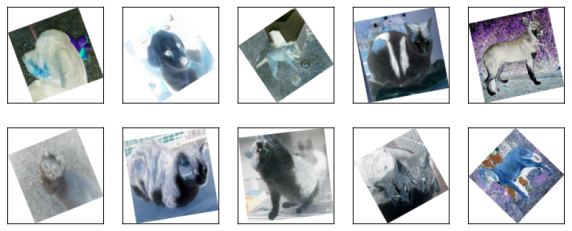

: 

In [10]:
# imgs = (batch[0][0:10].permute(0, 2, 3, 1))
# axes = d2l.show_images(imgs, 2, 5, scale=2)

搭建网络流水线

这里定义基础的残差块，如果是每一个阶段第一个块要做下采样处理

In [ ]:
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1,gdc = 4):
        super().__init__()
        gd=(num_channels//gdc)
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=gd,
                               kernel_size=1,  stride=1,bias=False)
        self.conv2 = nn.Conv2d(gd, gd,
                               kernel_size=3, padding=1, stride=strides,bias=False)
        self.conv3 = nn.Conv2d(gd, num_channels,
                               kernel_size=1,  stride=1,bias=False)
        if use_1x1conv:
            self.conv4 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides,bias=False)
            self.bn4 = nn.BatchNorm2d(num_channels)
        else:
            self.conv4 = None
        self.bn1 = nn.BatchNorm2d(gd)
        self.bn2 = nn.BatchNorm2d(gd)
        self.bn3 = nn.BatchNorm2d(num_channels)
        self.re = nn.ReLU(inplace=True)

    def forward(self, X):
        identity = X

        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = self.re(Y)

        Y = self.conv2(Y)
        Y = self.bn2(Y)
        Y = self.re(Y)

        Y = self.conv3(Y)
        Y = self.bn3(Y)

        if self.conv4:
            identity = self.conv4(X)
            identity = self.bn4(identity)
        
        Y += identity
        Y = self.re(Y)
        return Y

        # Y = self.re(self.bn1(self.conv1(X)))
        # Y = self.re(self.bn1(self.conv2(Y)))
        # Y = self.bn2(self.conv3(Y))
        # if self.conv4:
        #     X = self.bn2(self.conv4(X))
        # Y += X
        # Y = self.re(Y)
        # return Y

得到一个残差块的函数

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,str,gdcw):
    blk = []
    for i in range(num_residuals):
        if i == 0 :
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=str,gdc=gdcw))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

定义网络

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                   nn.BatchNorm2d(64), nn.ReLU(inplace=True),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2= nn.Sequential(*resnet_block(64,256,3,1,4))
b3= nn.Sequential(*resnet_block(256,512,4,2,4))
b4= nn.Sequential(*resnet_block(512,1024,6,2,4))
b5= nn.Sequential(*resnet_block(1024,2048,3,2,4))


net = nn.Sequential(b1,b2,b3,b4,b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),nn.Linear(2048, 2))

随机输入一个变量查看网络构造是否有问题

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
print(X)
# for inputs, labels in trainloader:
#     print(inputs.shape)
#     break;

# print(accuracy(X,torch.tensor([1])))
    

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 56, 56])
Sequential output shape:	 torch.Size([1, 512, 28, 28])
Sequential output shape:	 torch.Size([1, 1024, 14, 14])
Sequential output shape:	 torch.Size([1, 2048, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 2048, 1, 1])
Flatten output shape:	 torch.Size([1, 2048])
Linear output shape:	 torch.Size([1, 2])
tensor([[-0.6525,  0.3294]], grad_fn=<AddmmBackward0>)


定义训练函数

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    #net.apply(init_weights)
    #print(net[1][0].state_dict())
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            #if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                #animator.add(epoch + (i + 1) / num_batches,
                #             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        print(f'epoch:{epoch}')
        # print("trainacc:"+train_acc)
        # print("testacc:"+test_acc)
        # print("loss"+train_l)
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
        #animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

对网络初始化

In [ ]:
def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(256, eps=

下载官方搭建的resnet50，检查参数量是否一直，再次检查网络搭建情况

In [ ]:
resnet_model = torchvision.models.resnet50(pretrained=False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)
#resnet_model
# resnet_model.to(try_gpu())


f:\App\Pythonenvironment\base_deeplearningenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\App\Pythonenvironment\base_deeplearningenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

参数对比检查

In [ ]:
#train(net,trainloader,vaildloader,20,0.005,try_gpu())


def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

total_params = 0
for name, child in net.named_children():
    params = count_params(child)
    total_params += params
    print("{}的参数量：{}个".format(name, params))

print("总参数量：{}个".format(total_params))

0的参数量：9536个
1的参数量：215808个
2的参数量：1219584个
3的参数量：7098368个
4的参数量：14964736个
5的参数量：0个
6的参数量：0个
7的参数量：4098个
总参数量：23512130个


In [ ]:
total_params = 0
for name, child in resnet_model.named_children():
    params = count_params(child)
    total_params += params
    print("{}的参数量：{}个".format(name, params))

print("总参数量：{}个".format(total_params))

conv1的参数量：9408个
bn1的参数量：128个
relu的参数量：0个
maxpool的参数量：0个
layer1的参数量：215808个
layer2的参数量：1219584个
layer3的参数量：7098368个
layer4的参数量：14964736个
avgpool的参数量：0个
fc的参数量：4098个
总参数量：23512130个


正式训练

In [ ]:
#train(net,trainloader,vaildloader,5,0.004,try_gpu())

training on cuda:0
epoch:0
loss 1.083, train acc 0.515, test acc 0.503
epoch:1
loss 0.780, train acc 0.573, test acc 0.516
epoch:2
loss 0.722, train acc 0.613, test acc 0.503
epoch:3
loss 0.712, train acc 0.626, test acc 0.502
epoch:4
loss 0.685, train acc 0.638, test acc 0.506
epoch:5
loss 0.658, train acc 0.655, test acc 0.503
epoch:6
loss 0.625, train acc 0.681, test acc 0.537
epoch:7
loss 0.624, train acc 0.686, test acc 0.512
epoch:8
loss 0.602, train acc 0.697, test acc 0.503
epoch:9
loss 0.585, train acc 0.711, test acc 0.503
epoch:10
loss 0.580, train acc 0.716, test acc 0.503
epoch:11
loss 0.542, train acc 0.739, test acc 0.503
epoch:12
loss 0.532, train acc 0.743, test acc 0.503
epoch:13
loss 0.499, train acc 0.766, test acc 0.503
epoch:14
loss 0.478, train acc 0.776, test acc 0.503
epoch:15
loss 0.453, train acc 0.791, test acc 0.503
epoch:16
loss 0.427, train acc 0.806, test acc 0.503
epoch:17
loss 0.419, train acc 0.816, test acc 0.506
epoch:18
loss 0.394, train acc 0.824, test acc 0.503
epoch:19
loss 0.372, train acc 0.839, test acc 0.510
loss 0.372, train acc 0.839, test acc 0.510
176.6 examples/sec on cuda:0


保存训练结果

In [ ]:
#torch.save(net.state_dict(), 'net_25.params')

用网络做预测

In [ ]:
def predict(net, test_iter):
    all_preds = []
    net.to(try_gpu())
    for X in test_iter:
        halfpreds = net(X.to(try_gpu()))   #.float()
        halfpreds = halfpreds.detach().to('cpu').numpy()
        if len(halfpreds.shape) > 1 and halfpreds.shape[1] > 1:
            preds = halfpreds.argmax(axis=1)
        all_preds.extend(preds)
    return all_preds       

In [ ]:
file_names = os.listdir('C:\\Users\\Zhiweic\\Desktop\\catdog\\test')
# 去掉文件名中的'.jpg'后缀，作为ID
ids = [filename[:-4] for filename in file_names]
#阴间排序规则，只能手动筛选拉
idxtrue = []
for i in range(10000):
    if str(i) in ids:
        idxtrue.append(str(i))
submission = pd.DataFrame({
    'Id': idxtrue, 
    'Prediction': predict(net,test_iter)  # 预测结果
})
submission.to_csv('submission1.csv', index=False)